<h1>Part 1: Classifying Crimes with Machine Learning</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
root = ''
data_path = os.path.join(root, 'data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()

<br>For the given task, we look to build a pipeline for which we have the following subtasks:<br>
1) Data Exploration<br>
2) Data Preprocessing<br>
3) Modeling
<br><br>

In [4]:
# Read train dataset
train_df = pd.read_csv(os.path.join(data_path, 'Crime Descriptions - crime-descriptions.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'Crime Descriptions - uncategorized.csv'))
train_df.head()

,description,category
0,LARCENY/THEFT,Property Crime
1,BMV,Property Crime
2,LARCENY/THEFT,Property Crime
3,Petit Larceny,Property Crime
4,AUTO THEFT/PASSENGER VEHICLE,Property Crime


<br><h3>1) Data Exploration: Analyze dataset for finding the best preprocessing and modeling techniques</h3>
By looking at the data, we see that the preview descriptions are composed of key words and really short descriptions only, so language modeling might not be required, but lets see if thats true for the entire dataset. 
<br><br>

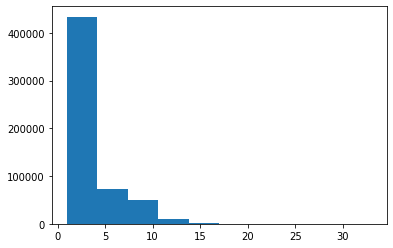

In [5]:
train_df['sentence_lenght'] = train_df['description'].apply(lambda x: len(x.split(' ')))
_ = plt.hist(train_df['sentence_lenght'])

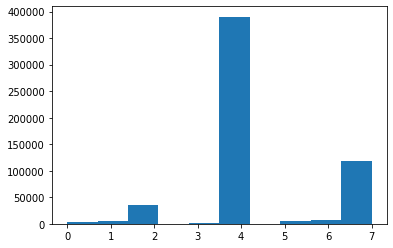

In [6]:
_ = plt.hist(train_df['category'].astype('category').cat.codes)

The classes are imbalanced, so if the class wise precision scores are not good enough, we will have to deal with it seperatly. 

<br><h3>2) Data Preprocessing</h3>
We will look to transform the string data to a machine readable format and also look to do some feature extraction which will help the model during the classification task 
<br><br>

From the problem description, we know the 8 crime categories we need the classify the given text into. We also have a few examples for each categories, using which we can come up with an important key word dictionary which we will be used for keyword matching with the text description and pass as additional features to our model. 
<br><br>

In [7]:
keyword_dict = {'Property Crime': ['arson', 'burglar', 'break', 'enter', 'destruct', 'theft', 'car', 'vehicle', 'motor', 'steal', 'property', 'curfew', 'loitering', 'trespass'],
               'Violent Crime': ['assault', 'homicide', 'rob', 'murder'],
               'Substance-related Crime': ['drug', 'narcotic', 'influence', 'drunk', 'liquor', 'substance'],
               'Sex Crime': ['pornography', 'obscene', 'prostitute', 'sex', 'peep', 'human-trafficking'],
               'Personal Crime (nonviolent)': ['kidnap', 'abduct', 'runaway'],
                'Financial Crime': ['bribery', 'counterfeiting', 'forgery', 'embezzlement', 'extrotion', 'blackmail', 'fraud'],
               'No Crime Committed': [],
               'Other': ['gambling', 'weapon', 'trafic']}
encoding_dict = {'Property Crime': 0,
               'Violent Crime': 1,
               'Substance-related Crime': 2,
               'Sex Crime': 3,
               'Personal Crime (nonviolent)': 4,
                'Financial Crime': 5,
               'No Crime Committed': 6,
               'Other': 7,
                'Not Classified': -1}
inc_encoding_dict = {}
for d in encoding_dict:
    inc_encoding_dict[encoding_dict[d]] = d

Even though all keywords are in thier base form, we can pass all of them through the lematizer to make sure since all key word matching will take place in base form. 
For example, 'rock' and 'rocks' are the same word, but will not match on comparison and so we need compare both of them in base form. 

In [8]:
import spacy

nlp = spacy.load('en_core_web_sm')
inv_keyword_dict = {}

for category in keyword_dict:
    for n, keyword in enumerate(keyword_dict[category]):
        keyword_dict[category][n] = nlp(keyword)[0].lemma_
        inv_keyword_dict[keyword] = category

In [9]:
train_df['category'].unique()

array(['Property Crime', 'Violent Crime', 'Other',
       'Substance-related Crime', 'Sex Crime', 'No Crime Committed',
       'Financial Crime', 'Personal Crime (nonviolent)'], dtype=object)

In [10]:
train_df['word_vec'] = train_df['description'].astype(object)
train_df['features'] = train_df['description'].astype(object)
word_dict = {}
word_dict_inv = {}
i = 0
for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    sentence = row['description']
    keywords_matched = {'Property Crime': 0,
                       'Violent Crime': 0,
                       'Substance-related Crime': 0,
                       'Sex Crime': 0,
                       'Personal Crime (nonviolent)': 0,
                        'Financial Crime': 0,
                       'No Crime Committed': 0,
                       'Other': 0}
    sentence = nlp(sentence)
    new_sentence = []
    for n, word in enumerate(sentence):
        word_lower = word.lemma_.lower()
        if word_lower not in word_dict:
            word_dict[word_lower] = i
            word_dict_inv[i] = word_lower
            i += 1
        new_sentence.append(word_dict[word_lower])
        if word_lower in inv_keyword_dict:
            keywords_matched[inv_keyword_dict[word_lower]] += 1
    train_df.at[idx, 'word_vec'] = new_sentence
    train_df.at[idx, 'features'] = list(keywords_matched.values())
    train_df.at[idx, 'category'] = encoding_dict[train_df.at[idx, 'category']]
train_df

100%|██████████| 567540/567540 [36:22<00:00, 260.07it/s] 


,description,category,sentence_lenght,word_vec,features
0,LARCENY/THEFT,0,1,"[0, 1, 2]","[1, 0, 0, 0, 0, 0, 0, 0]"
1,BMV,0,1,[3],"[0, 0, 0, 0, 0, 0, 0, 0]"
2,LARCENY/THEFT,0,1,"[0, 1, 2]","[1, 0, 0, 0, 0, 0, 0, 0]"
3,Petit Larceny,0,2,"[4, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
4,AUTO THEFT/PASSENGER VEHICLE,0,3,"[5, 2, 1, 6, 7]","[2, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
567535,"Theft, From Unlocked Vehicle, $200-$950",0,5,"[2, 37, 21, 333, 7, 37, 61, 280]","[2, 0, 0, 0, 0, 0, 0, 0]"
567536,Petit Larceny,0,2,"[4, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
567537,UUV,0,1,[50],"[0, 0, 0, 0, 0, 0, 0, 0]"
567538,LARCENY/THEFT,0,1,"[0, 1, 2]","[1, 0, 0, 0, 0, 0, 0, 0]"


Now we have our vocab from our train set. We need to use the same vocab to create word vec of our test set

In [18]:
word_dict['<UNK>'] = i
word_dict['<PAD>'] = i+1
word_dict_inv[i] = '<UNK>'
word_dict_inv[i+1] = '<PAD>'

In [12]:
test_df['word_vec'] = test_df['description'].astype(object)
test_df['features'] = test_df['description'].astype(object)
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    sentence = row['description']
    keywords_matched = {'Property Crime': 0, 
                    'Violent Crime': 0,
                    'Substance-related Crime': 0, 
                    'Sex Crime': 0, 
                    'Personal Crime (nonviolent)': 0, 
                    'Financial Crime': 0,
                    'No Crime Committed': 0, 
                    'Other': 0}
    sentence = nlp(sentence)
    new_sentence = []
    for n, word in enumerate(sentence):
        word_lower = word.lemma_.lower()
        if word_lower in word_dict:
            new_sentence.append(word_dict[word_lower])
        else:
            new_sentence.append(word_dict['<UNK>'])
        if word_lower in inv_keyword_dict:
            keywords_matched[inv_keyword_dict[word_lower]] += 1
    test_df.at[idx, 'word_vec'] = new_sentence
    test_df.at[idx, 'features'] = list(keywords_matched.values())
test_df

100%|██████████| 500000/500000 [27:58<00:00, 297.81it/s] 


,description,word_vec,features
0,FRAUD - ALL OTHER,"[110, 13, 186, 35]","[0, 0, 0, 0, 0, 1, 0, 0]"
1,6G,"[1661, 145]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,PETIT FROM BUILD..,"[4, 21, 835, 2300]","[0, 0, 0, 0, 0, 0, 0, 0]"
3,BURGLARY CONVEYANCE,"[23, 2300]","[0, 0, 0, 0, 0, 0, 0, 0]"
4,INFORMATION,[332],"[0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
499995,PETIT OF BICYCLE,"[4, 10, 436]","[0, 0, 0, 0, 0, 0, 0, 0]"
499996,PETIT OF VEHICLE..,"[4, 10, 7, 2300]","[1, 0, 0, 0, 0, 0, 0, 0]"
499997,INFORMATION,[332],"[0, 0, 0, 0, 0, 0, 0, 0]"
499998,ASSAULT 3,"[15, 481]","[0, 1, 0, 0, 0, 0, 0, 0]"


In [13]:
from torch.utils.data import Dataset, DataLoader

class CrimeDiscriptions(Dataset):
    def __init__(self, df, word_dict, test=False):
        self.data = df['word_vec']
        self.features = df['features']
        sent_len = self.data.apply(len)
        self.pad_length = sent_len.max()
        self.word_dict = word_dict
        self.test = test
        if not test:
            self.lables = df['category']
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_pad = self.data.iloc[idx]
        data_pad += [self.word_dict['<PAD>']] * (self.pad_length - len(data_pad))
        out = [torch.as_tensor(data_pad).float(), torch.as_tensor(self.features.iloc[idx]).float()]
        if not self.test:
            out.append(torch.as_tensor(self.lables.iloc[idx]).float())
        return out

transformed_dataset = CrimeDiscriptions(train_df, word_dict)
dataloader = DataLoader(transformed_dataset, batch_size=8, shuffle=True)
for data, features, labels in dataloader:
    print(data.shape, features.shape, labels.shape)
    break

torch.Size([8, 44]) torch.Size([8, 8]) torch.Size([8])


With all the data transformed and ready, we can move to our model.

<br><br>
<h3>3) Model</h3>
<br><br>

In [19]:
# hyperparameters

epochs = 25
lr = 1e-3
batch_size = 32
dropout_prob = 0.5
train_tvalid_split_ratio = 0.8
num_labels = 8
embedding_dim = 64
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
import torch.nn as nn
from transformers import BertModel

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout_prob, hidden_size=8, num_labels=8):
        super(LSTM, self).__init__()
        self.num_labels = num_labels
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, dropout=dropout_prob, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size + num_labels, num_labels)
    def forward(self, x, features):
        x = self.embeddings(x)
        out, (ht, ct) = self.lstm(x)
        out = torch.cat((ht[-1], features), 1)
        out = self.fc(out)
        return out

In [21]:
model = LSTM(len(word_dict), embedding_dim, dropout_prob, hidden_size, num_labels).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
transformed_dataset = CrimeDiscriptions(train_df, word_dict)
train_size = int(len(transformed_dataset) * train_tvalid_split_ratio)
test_size = len(transformed_dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [23]:
# Helper functin to remove predictions with low confidence 
def remove_low_conf(y_true, y_pred, threshold=0.65):
    y_pred = nn.functional.softmax(y_pred)
    y_pred, y_pred_class = y_pred.max(1)
    low_conf = y_pred < threshold
    y_pred_class[low_conf] = -1
    y_true = y_true.clone()
    y_true[low_conf] = -1
    return y_true, y_pred_class

In [24]:
for epoch in range(epochs):
    epoch_loss = 0
    train_correct, train_total, train_low_conf = 0, 0, 0
    for data, features, labels in train_loader:
        optimizer.zero_grad()
        out = model(data.long().to(device), features.to(device))
        loss = criterion(out.cpu(), labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        labels, out = remove_low_conf(labels, out)
        low_conf = (labels == -1).sum()
        train_correct += (labels == out).sum() - low_conf
        train_total += labels.shape[0] - low_conf
        train_low_conf += low_conf
    valid_loss = 0
    valid_correct, valid_total, valid_low_conf = 0, 0, 0
    with torch.no_grad():
        for data, features, labels in valid_loader:
            optimizer.zero_grad()
            out = model(data.long().to(device), features.to(device))
            loss = criterion(out.cpu(), labels.long())
            valid_loss += loss.item()
            labels, out = remove_low_conf(labels, out)
            low_conf = (labels == -1).sum()
            valid_correct += (labels == out).sum() - low_conf
            valid_total += labels.shape[0] - low_conf
            valid_low_conf += low_conf
    train_acc = train_correct/(train_total+1e-6)
    valid_acc = valid_correct/(valid_total+1e-6)
    train_low_conf = train_low_conf/(train_total+train_low_conf)
    valid_low_conf = valid_low_conf/(valid_total+valid_low_conf)
    print("Epoch: {}\tTrain loss: {:.3f}\tTrain Acc: {:.3f}\tTrain unclassified: {:.3f}\tValid loss: {:.3f}\tValid Acc: {:.3f}\tValid unclassified: {:.3f}".format(
        epoch, epoch_loss, train_acc, train_low_conf, valid_loss, valid_acc, valid_low_conf))

<ipython-input-23-166be8afa6b6>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = nn.functional.softmax(y_pred)


Epoch: 0	Train loss: 345.417	Train Acc: 0.999	Train unclassified: 0.012	Valid loss: 14.455	Valid Acc: 1.000	Valid unclassified: 0.004
Epoch: 1	Train loss: 46.710	Train Acc: 0.999	Train unclassified: 0.002	Valid loss: 10.844	Valid Acc: 0.999	Valid unclassified: 0.000
Epoch: 2	Train loss: 35.904	Train Acc: 1.000	Train unclassified: 0.002	Valid loss: 11.021	Valid Acc: 1.000	Valid unclassified: 0.003
Epoch: 3	Train loss: 33.208	Train Acc: 1.000	Train unclassified: 0.002	Valid loss: 10.373	Valid Acc: 1.000	Valid unclassified: 0.003
Epoch: 4	Train loss: 31.448	Train Acc: 1.000	Train unclassified: 0.002	Valid loss: 10.476	Valid Acc: 1.000	Valid unclassified: 0.003
Epoch: 5	Train loss: 30.733	Train Acc: 1.000	Train unclassified: 0.002	Valid loss: 9.930	Valid Acc: 1.000	Valid unclassified: 0.003


KeyboardInterrupt: 

Now that we have our model trained, lets evaluate some metrics on our validation set. 

In [25]:
from sklearn.metrics import classification_report

y_pred, y_true = [], []
valid_correct, valid_total, valid_low_conf = 0, 0, 0
with torch.no_grad():
    for data, features, labels in valid_loader:
        optimizer.zero_grad()
        out = model(data.long().to(device), features.to(device))
        labels, out = remove_low_conf(labels, out)
        y_pred.append(out)
        y_true.append(labels)
        low_conf = (labels == -1).sum()
        valid_correct += (labels == out).sum() - low_conf
        valid_total += labels.shape[0] - low_conf
        valid_low_conf += low_conf
print('Precision: ', classification_report(torch.cat(y_true), torch.cat(y_pred)))

<ipython-input-23-166be8afa6b6>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = nn.functional.softmax(y_pred)


Precision:                precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       344
         0.0       1.00      1.00      1.00     77808
         1.0       1.00      1.00      1.00     23730
         2.0       1.00      1.00      1.00      1278
         3.0       1.00      1.00      1.00      1082
         4.0       0.99      0.99      0.99       317
         5.0       1.00      0.99      1.00       769
         6.0       1.00      1.00      1.00      1075
         7.0       1.00      1.00      1.00      7105

    accuracy                           1.00    113508
   macro avg       1.00      1.00      1.00    113508
weighted avg       1.00      1.00      1.00    113508



The predictions with lower confidence were classified as class -1. Out of the 20000 examples in validation set, 7 were classfied as -1. The precision scores for all the classes were high, and if even higher precision is needed, the remove_low_conf takes an additional threshold parameter which can be set to a higher value. 

<br><br>
The only task left is to classify the test set. 

In [ ]:
transformed_dataset_test = CrimeDiscriptions(test_df, word_dict, test=True)
test_loader = DataLoader(transformed_dataset_test, batch_size=1, shuffle=True)

y_pred = []
with torch.no_grad():
    for data, features in tqdm(test_loader):
        out = model(data.long().to(device), features.to(device))
        out = out.max(1)[1]
        y_pred.append(out)
y_pred = torch.cat(y_pred)
test_df['prediction'] = y_pred.numpy()

  6%|▌         | 30380/500000 [01:09<17:51, 438.47it/s]

In [ ]:
test_df['prediction'] = test_df['prediction'].apply(lambda x: inc_encoding_dict[x])

In [ ]:
test_df

In [ ]:
test_df.to_csv(os.path.join(data_path, 'CrimeDescriptions.csv'))

Summary: 
<br>
- CrimeDescriptions.csv file has the classes filled in with the predictions.<br>
- The precision scores for all the classes are high, but we have another class with for items classified with low confidence. <br>
- Additional feature extracted in form word word matching helped increasing the precision scores. <br>